In [96]:
import time 
import requests
import json
import datetime 

def get_stages(app_id):
    print(app_id)
    URL = "http://neu-3-1:18080/api/v1/applications/%s/stages"%(app_id)
    # sending get request and saving the response as response object 
    if URL == "http://neu-3-1:18080/api/v1/applications/app-20200617160405-0036/stages":
        print(URL)
        
    URL="http://neu-3-1:18080/api/v1/applications/app-20200617160405-0036/stages"
        
    r = requests.get(url = URL) 
    #print(r)
    # extracting data in json format 
    stages = r.json() 

    for s in stages:
        submit_time = time.mktime(datetime.datetime.strptime(s['submissionTime'], 
                                                     "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())        
        start_time = time.mktime(datetime.datetime.strptime(s['firstTaskLaunchedTime'], 
                                                     "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())
        completion_time = time.mktime(datetime.datetime.strptime(s['completionTime'], 
                                                     "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())
        #print(s['stageId'], s['inputBytes'], s['outputBytes'], s['rddIds'],
        #      s['numTasks'], completion_time - submit_time)
        
        #print(s.keys())
        #break


# sending get request and saving the response as response object 
URL = "http://neu-3-1:18080/api/v1/applications"
r = requests.get(url = URL) 
applications = r.json() 
        
print(len(applications))
for app in applications:
    if app['id'] == 'app-20200619153707-0673':
        print(app['attempts'][0]['duration'])
        break
    
    
r

683
41820


<Response [200]>

Index(['app_id', 'app_name', 'stage_id', 'input_sz', 'output_sz', 'rdds',
       'n_tasks', 'runtime', 'name', 'bw', 'dataset', 'stride', 'rep',
       'app_runtime', 'bw_i', 'dataset_i'],
      dtype='object')
              Coefficient
remote_read  6.668231e+01
cache_read   1.170517e+00
sequential   1.627258e-08


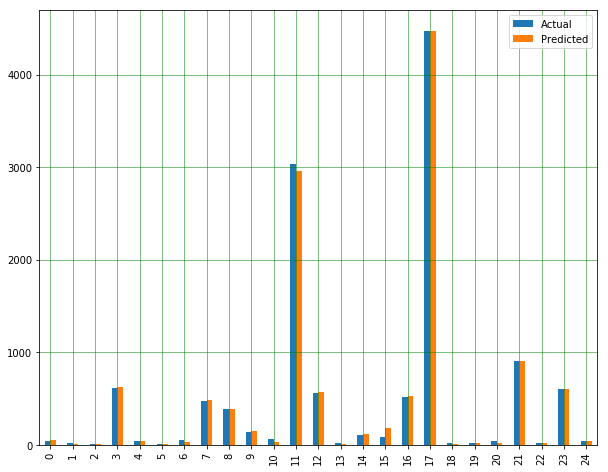

Mean Absolute Error: 9.985143217343674
Mean Squared Error: 337.95555575520507
Root Mean Squared Error: 18.383567547002542


In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df = pd.read_csv('/local0/Kariz/expriments/runtime_prediction/micro/results/wordcount-spark.csv')
df['bw_i'] = df['bw'].apply(lambda bws: float(bws.replace('Gbps', '')) if 'Gbps' in bws else float(bws.replace('Mbps', ''))/1000)
df['dataset_i'] = df['dataset'].str.replace(r'G', '').astype(int)

df1 = df[df['stage_id'] == 0]

print(df.columns)
cache_block_sz = 4*1024*1024
bw_cache = 5*(10**9)

def reshape_data(row):
    if row['n_tasks']*row['stride']*cache_block_sz > row['input_sz']:
        return row['input_sz']/bw_cache
    return row['n_tasks']*row['stride']*cache_block_sz/bw_cache
    




df2 = pd.DataFrame()
df2['input_sz'] = df1['input_sz']
df2['remote_read'] = (df1['input_sz'] - df1['n_tasks']*df1['stride']*cache_block_sz)/(df1['bw_i']*8*(10**9))
df2['remote_read'] = df2['remote_read'].apply(lambda rread: 0 if rread < 0 else rread)
df2['cache_read'] = df1.apply(reshape_data, axis=1)
df2['sequential'] = df1['input_sz']/df1['n_tasks']
    

X = df2[['remote_read', 'cache_read', 'sequential']].values

Y= df1['runtime'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


regressor = LinearRegression()  
regressor.fit(X_train, y_train)

coeff_df = pd.DataFrame(regressor.coef_, 
                       df2[['remote_read', 'cache_read', 'sequential']].columns, 
                        columns=['Coefficient'])  
print(coeff_df)

y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

df1 = df.head(25)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



Index(['app_id', 'app_name', 'stage_id', 'input_sz', 'output_sz', 'rdds',
       'n_tasks', 'runtime', 'name', 'bw', 'dataset', 'stride', 'rep',
       'app_runtime', 'bw_i', 'dataset_i'],
      dtype='object')
              Coefficient
remote_read  6.668231e+01
cache_read   1.170517e+00
sequential   1.627258e-08


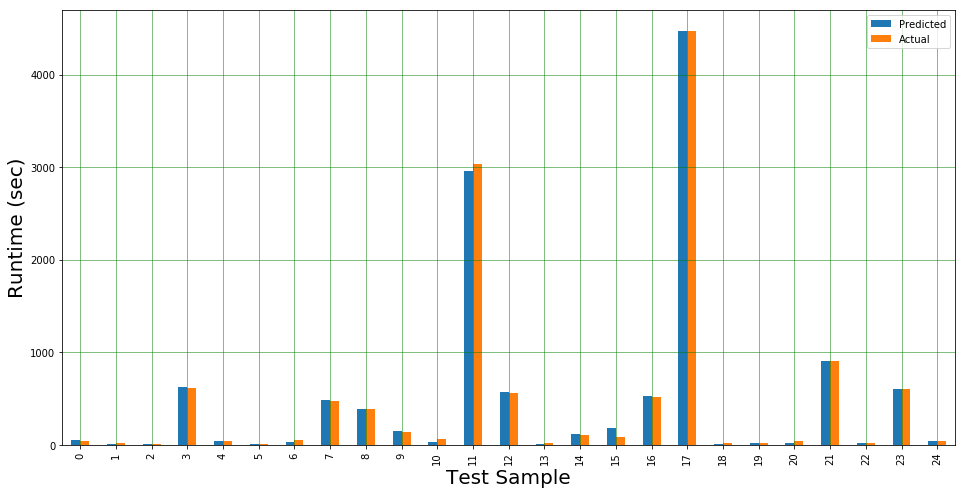

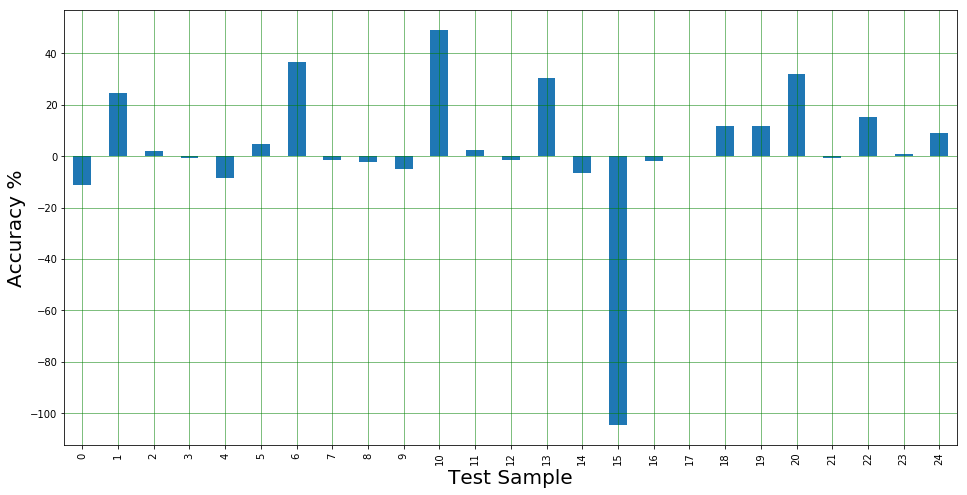

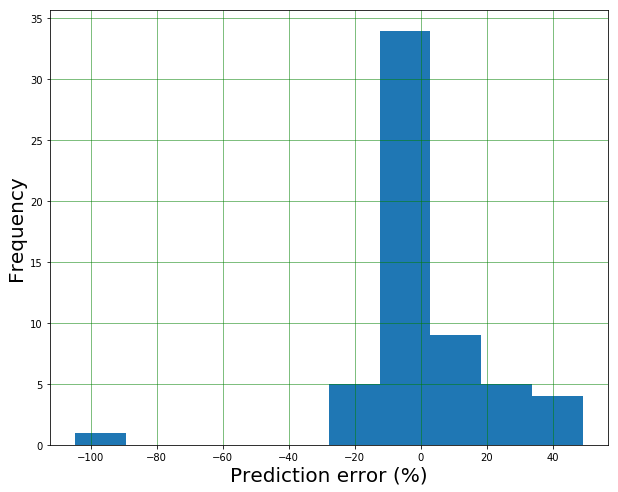

Mean Absolute Error: 9.985143217343674
Mean Squared Error: 337.95555575520507
Root Mean Squared Error: 18.383567547002542


,Actual,Predicted,Accuracy
0,49.0,54.432846,-11.087440
1,21.0,15.835777,24.591539
2,9.0,8.823101,1.965547
3,620.0,625.335598,-0.860580
4,40.0,43.474751,-8.686877
5,8.0,7.628299,4.646268
6,50.0,31.703731,36.592539
7,477.0,484.147359,-1.498398
8,384.0,393.326479,-2.428771
9,145.0,152.397012,-5.101387


In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df = pd.read_csv('/local0/Kariz/expriments/runtime_prediction/micro/results/wordcount-spark.csv')
df['bw_i'] = df['bw'].apply(lambda bws: float(bws.replace('Gbps', '')) if 'Gbps' in bws else float(bws.replace('Mbps', ''))/1000)
df['dataset_i'] = df['dataset'].str.replace(r'G', '').astype(int)

df1 = df[df['stage_id'] == 0]

print(df.columns)
cache_block_sz = 4*1024*1024
bw_cache = 5*(10**9)

def reshape_data(row):
    if row['n_tasks']*row['stride']*cache_block_sz > row['input_sz']:
        return row['input_sz']/bw_cache
    return row['n_tasks']*row['stride']*cache_block_sz/bw_cache
    




df2 = pd.DataFrame()
df2['input_sz'] = df1['input_sz']
df2['remote_read'] = (df1['input_sz'] - df1['n_tasks']*df1['stride']*cache_block_sz)/(df1['bw_i']*8*(10**9))
df2['remote_read'] = df2['remote_read'].apply(lambda rread: 0 if rread < 0 else rread)
df2['cache_read'] = df1.apply(reshape_data, axis=1)
df2['sequential'] = df1['input_sz']/df1['n_tasks']
    

X = df2[['remote_read', 'cache_read', 'sequential']].values

Y= df1['runtime'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


regressor = LinearRegression()  
regressor.fit(X_train, y_train)

coeff_df = pd.DataFrame(regressor.coef_, 
                       df2[['remote_read', 'cache_read', 'sequential']].columns, 
                        columns=['Coefficient'])  
print(coeff_df)

y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df['Accuracy'] = 100*(1 - df['Predicted']/df['Actual'])

df1 = df.head(25)

fig, ax = plt.subplots(figsize=(16, 8))
df1[['Predicted', 'Actual']].plot(kind='bar',ax=ax)
ax.set_xlabel('Test Sample', fontsize=20)
ax.set_ylabel('Runtime (sec)', fontsize=20)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

fig, ax = plt.subplots(figsize=(16, 8))
df1['Accuracy'].plot(kind='bar', ax=ax)
ax.set_xlabel('Test Sample', fontsize=20)
ax.set_ylabel('Accuracy %', fontsize=20)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()


fig, ax = plt.subplots(figsize=(10, 8))
df['Accuracy'].plot(kind='hist', ax=ax)
ax.set_xlabel('Prediction error (%)', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

df.head(25)

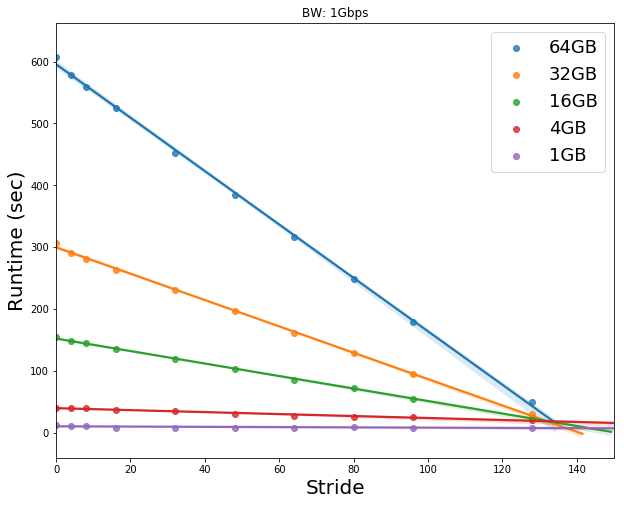

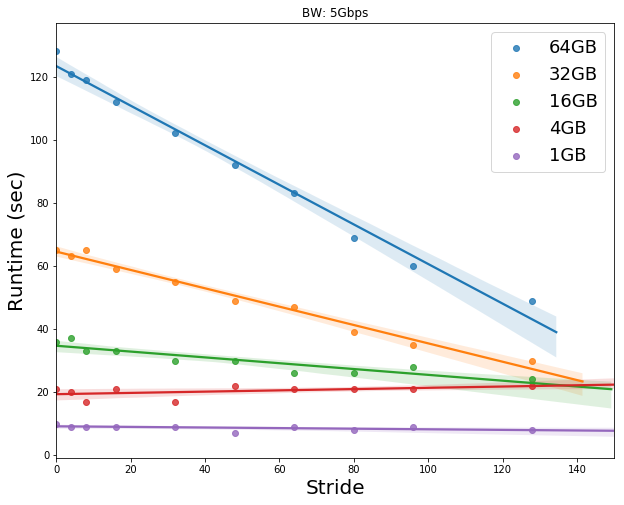

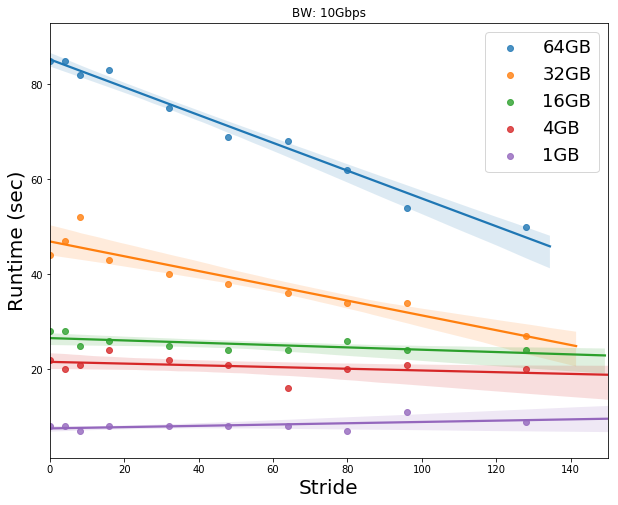

,app_id,app_name,stage_id,input_sz,output_sz,rdds,n_tasks,runtime,name,bw,dataset,stride,rep,app_runtime
0,app-20200629141853-0012,name:wordcount-bw:1Gbps-ds:32G-stride:64-rep:0...,1,0,28655,"[6, 5]",64,7.0,wordcount,1Gbps,32G,64,0,178304
1,app-20200629141853-0012,name:wordcount-bw:1Gbps-ds:32G-stride:64-rep:0...,0,35271691558,0,"[4, 0, 1, 2, 3]",64,161.0,wordcount,1Gbps,32G,64,0,178304
2,app-20200629142707-0013,name:wordcount-bw:1Gbps-ds:32G-stride:128-rep:...,1,0,28655,"[6, 5]",64,6.0,wordcount,1Gbps,32G,128,0,0
3,app-20200629142707-0013,name:wordcount-bw:1Gbps-ds:32G-stride:128-rep:...,0,35271691558,0,"[4, 3, 2, 1, 0]",64,30.0,wordcount,1Gbps,32G,128,0,0
4,app-20200629142836-0014,name:wordcount-bw:1Gbps-ds:32G-stride:8-rep:0-...,1,0,28655,"[6, 5]",64,6.0,wordcount,1Gbps,32G,8,0,0
5,app-20200629142836-0014,name:wordcount-bw:1Gbps-ds:32G-stride:8-rep:0-...,0,35271691558,0,"[4, 3, 0, 2, 1]",64,281.0,wordcount,1Gbps,32G,8,0,0
6,app-20200629143433-0015,name:wordcount-bw:1Gbps-ds:32G-stride:16-rep:0...,1,0,28655,"[6, 5]",64,9.0,wordcount,1Gbps,32G,16,0,0
7,app-20200629143433-0015,name:wordcount-bw:1Gbps-ds:32G-stride:16-rep:0...,0,35271691558,0,"[4, 0, 1, 3, 2]",64,263.0,wordcount,1Gbps,32G,16,0,0
8,app-20200629144052-0016,name:wordcount-bw:1Gbps-ds:32G-stride:32-rep:0...,1,0,28655,"[6, 5]",64,6.0,wordcount,1Gbps,32G,32,0,243675
9,app-20200629144052-0016,name:wordcount-bw:1Gbps-ds:32G-stride:32-rep:0...,0,35271691558,0,"[4, 2, 3, 1, 0]",64,231.0,wordcount,1Gbps,32G,32,0,243675


In [3]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df = pd.read_csv('/local0/Kariz/expriments/runtime_prediction/micro/results/wordcount-spark.csv')


fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(x='stride', y='runtime', ax=ax, label='64GB',
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)])


sns.regplot(x='stride', y='runtime', ax=ax,label='32GB',
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='32G') & (df['stage_id']==0)])


sns.regplot(x='stride', y='runtime', ax=ax, label='16GB',
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='16G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='4GB',
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='4G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='1GB',
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='1G') & (df['stage_id']==0)])

ax.set_xlabel('Stride', fontsize=20)
ax.set_ylabel('Runtime (sec)', fontsize=20)
ax.set_xlim(0, 150)
plt.legend(fontsize=18)
plt.title("BW: 1Gbps")
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(x='stride', y='runtime', ax=ax, label='64GB',
            data=df[(df['bw']=='5Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)])


sns.regplot(x='stride', y='runtime', ax=ax,label='32GB',
            data=df[(df['bw']=='5Gbps') & (df['dataset']=='32G') & (df['stage_id']==0)])


sns.regplot(x='stride', y='runtime', ax=ax,label='16GB',
            data=df[(df['bw']=='5Gbps') & (df['dataset']=='16G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='4GB',
            data=df[(df['bw']=='5Gbps') & (df['dataset']=='4G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='1GB',
            data=df[(df['bw']=='5Gbps') & (df['dataset']=='1G') & (df['stage_id']==0)])

ax.set_xlabel('Stride', fontsize=20)
ax.set_ylabel('Runtime (sec)', fontsize=20)
ax.set_xlim(0, 150)
plt.legend(fontsize=18)
plt.title("BW: 5Gbps")
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(x='stride', y='runtime', ax=ax,label='64GB',
            data=df[(df['bw']=='10Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)])


sns.regplot(x='stride', y='runtime', ax=ax,label='32GB',
            data=df[(df['bw']=='10Gbps') & (df['dataset']=='32G') & (df['stage_id']==0)])


sns.regplot(x='stride', y='runtime', ax=ax,label='16GB',
            data=df[(df['bw']=='10Gbps') & (df['dataset']=='16G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='4GB',
            data=df[(df['bw']=='10Gbps') & (df['dataset']=='4G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='1GB',
            data=df[(df['bw']=='10Gbps') & (df['dataset']=='1G') & (df['stage_id']==0)])

ax.set_xlabel('Stride', fontsize=20)
ax.set_xlim(0, 150)
ax.set_ylabel('Runtime (sec)', fontsize=20)
plt.legend(fontsize=18)
plt.title("BW: 10Gbps")
plt.show()




#df[['dataset', 'bw', 'stride', 'runtime', 'app_runtime']]
df

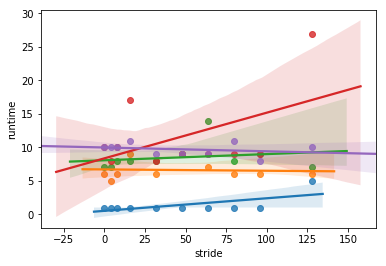

In [10]:

sns.regplot(x='stride', y='runtime', 
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='64G') & (df['stage_id']==1)])


sns.regplot(x='stride', y='runtime', 
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='32G') & (df['stage_id']==1)])


sns.regplot(x='stride', y='runtime', 
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='16G') & (df['stage_id']==1)])

sns.regplot(x='stride', y='runtime', 
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='4G') & (df['stage_id']==1)])

sns.regplot(x='stride', y='runtime', 
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='1G') & (df['stage_id']==1)])


#plt.legend()
plt.show()


In [33]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

df2 = pd.read_csv('/local0/Kariz/expriments/runtime_prediction/micro/results/wordcount-spark.csv')
df2 = df2[df2['stage_id'] == 0]

df2['bw_i'] = df2['bw'].str.replace(r'Gbps', '').astype(int)
df2['dataset_i'] = df2['dataset'].str.replace(r'G', '').astype(int)
df2['stride'] = 128 - (df2['stride'].astype(int))

df2[['bw_i', 'dataset_i', 'stride', 'n_tasks', 'runtime']]

,bw_i,dataset_i,stride,n_tasks,runtime
1,1,32,64,64,161.0
3,1,32,0,64,30.0
5,1,32,120,64,281.0
7,1,32,112,64,263.0
9,1,32,96,64,231.0
11,1,32,80,64,196.0
13,1,32,124,64,291.0
15,1,32,48,64,128.0
17,1,32,32,64,94.0
19,1,32,128,64,306.0


           Coefficient
bw_i         -8.691553
dataset_i     3.165634
stride        0.683689


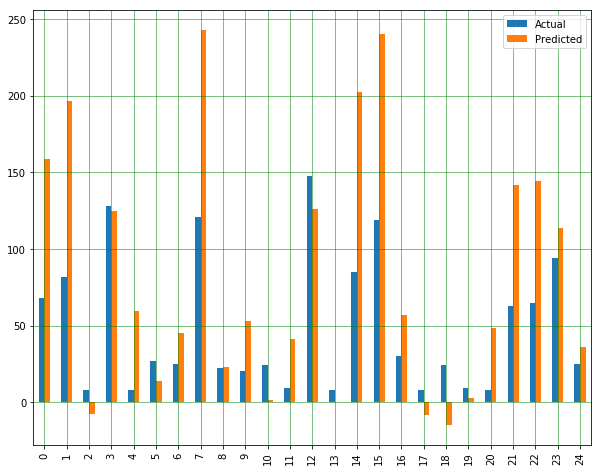

Mean Absolute Error: 45.65704175429106
Mean Squared Error: 3512.107979639248
Root Mean Squared Error: 59.263040587192684


In [37]:

X = df2[['bw_i', 'dataset_i', 'stride']].values

Y= df2['runtime'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


regressor = LinearRegression()  
regressor.fit(X_train, y_train)

coeff_df = pd.DataFrame(regressor.coef_, 
                        df2[['bw_i', 'dataset_i', 'stride']].columns, 
                        columns=['Coefficient'])  
print(coeff_df)

y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

df1 = df.head(25)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



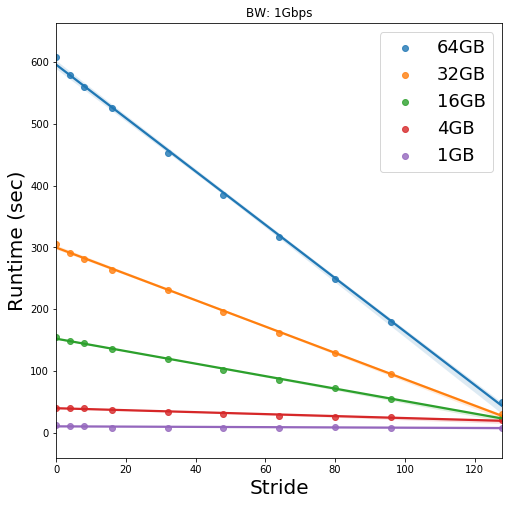

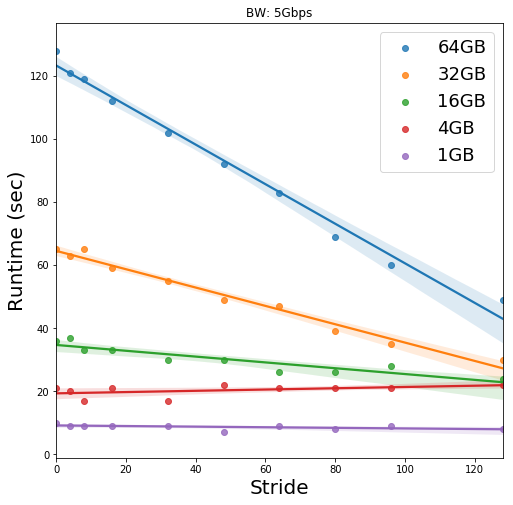

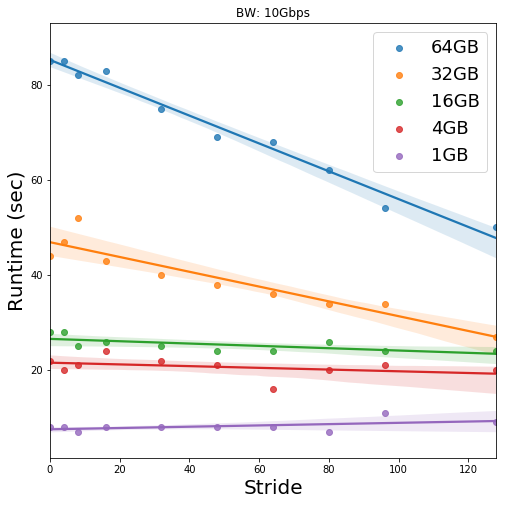

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df = pd.read_csv('/local0/Kariz/expriments/runtime_prediction/micro/results/wordcount-spark.csv')


fig, ax = plt.subplots(figsize=(8, 3))
sns.regplot(x='stride', y='runtime', ax=ax, label='64GB',
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)])


sns.regplot(x='stride', y='runtime', ax=ax,label='32GB',
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='32G') & (df['stage_id']==0)])


sns.regplot(x='stride', y='runtime', ax=ax, label='16GB',
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='16G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='4GB',
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='4G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='1GB',
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='1G') & (df['stage_id']==0)])

ax.set_xlabel('Stride', fontsize=20)
ax.set_ylabel('Runtime (sec)', fontsize=20)
ax.set_xlim(0, 128)
plt.legend(fontsize=18)
plt.title("BW: 1Gbps")
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(x='stride', y='runtime', ax=ax, label='64GB',
            data=df[(df['bw']=='5Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)])


sns.regplot(x='stride', y='runtime', ax=ax,label='32GB',
            data=df[(df['bw']=='5Gbps') & (df['dataset']=='32G') & (df['stage_id']==0)])


sns.regplot(x='stride', y='runtime', ax=ax,label='16GB',
            data=df[(df['bw']=='5Gbps') & (df['dataset']=='16G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='4GB',
            data=df[(df['bw']=='5Gbps') & (df['dataset']=='4G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='1GB',
            data=df[(df['bw']=='5Gbps') & (df['dataset']=='1G') & (df['stage_id']==0)])

ax.set_xlabel('Stride', fontsize=20)
ax.set_ylabel('Runtime (sec)', fontsize=20)
ax.set_xlim(0, 128)
plt.legend(fontsize=18)
plt.title("BW: 5Gbps")
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
sns.regplot(x='stride', y='runtime', ax=ax,label='64GB',
            data=df[(df['bw']=='10Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)])


sns.regplot(x='stride', y='runtime', ax=ax,label='32GB',
            data=df[(df['bw']=='10Gbps') & (df['dataset']=='32G') & (df['stage_id']==0)])


sns.regplot(x='stride', y='runtime', ax=ax,label='16GB',
            data=df[(df['bw']=='10Gbps') & (df['dataset']=='16G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='4GB',
            data=df[(df['bw']=='10Gbps') & (df['dataset']=='4G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='1GB',
            data=df[(df['bw']=='10Gbps') & (df['dataset']=='1G') & (df['stage_id']==0)])

ax.set_xlabel('Stride', fontsize=20)
ax.set_xlim(0, 128)
ax.set_ylabel('Runtime (sec)', fontsize=20)
plt.legend(fontsize=18)
plt.title("BW: 10Gbps")
plt.show()




#df[['dataset', 'bw', 'stride', 'runtime', 'app_runtime']]

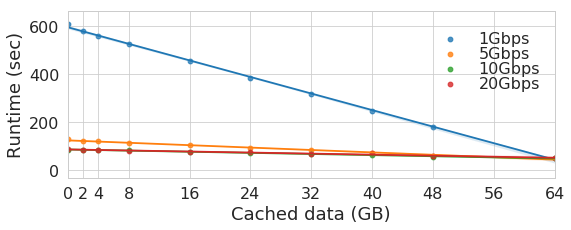

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


sns.set_style(style="whitegrid")
sns.set_context("paper")

def format_xticks(x, pos=None):
    #print(x//2)
    return str(x//2) 

df = pd.read_csv('/local0/Kariz/expriments/runtime_prediction/micro/results/wordcount-spark.csv')


fig, ax = plt.subplots(figsize=(8, 3))


#sns.regplot(x='stride', y='runtime', ax=ax, label='0.5Gbps',
#            data=df[(df['bw']=='500Mbps') & (df['dataset']=='64G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='1Gbps',
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='5Gbps',
            data=df[(df['bw']=='5Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax, label='10Gbps',
            data=df[(df['bw']=='10Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)])

sns.regplot(x='stride', y='runtime', ax=ax,label='20Gbps',
            data=df[(df['bw']=='20Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)])


ax.set_xlabel('Cached data (GB)', fontsize=18)
ax.set_ylabel('Runtime (sec)', fontsize=18)
ax.tick_params(labelsize=16)
ax.set_xticks([0,4,  8, 16, 32, 48, 64, 80, 96, 112, 128])
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
ax.set_xlim(0, 128)
#ax.set_ylim(0, 1200)
plt.legend(fontsize=16, loc=7, facecolor=None, framealpha=0, labelspacing=0,
         bbox_to_anchor=(1, 0.7))
plt.subplots_adjust(left=0.15, bottom=0.2, right=0.995, top=0.97)
fig.savefig('/local0/Kariz/code/ipython/fig_partialslope_runtime_wc_spark.pdf', format='pdf', dpi=200)
fig.savefig('/local0/Kariz/code/ipython/fig_partialslope_runtime_wc_spark.png', format='png', dpi=200)


plt.show()




In [10]:
gg = df.groupby(['bw', 'dataset'])
for index, g in gg:
    print(index)

('100Mbps', '32G')
('100Mbps', '64G')
('10Gbps', '16G')
('10Gbps', '1G')
('10Gbps', '32G')
('10Gbps', '4G')
('10Gbps', '64G')
('1Gbps', '16G')
('1Gbps', '1G')
('1Gbps', '32G')
('1Gbps', '4G')
('1Gbps', '64G')
('20Gbps', '16G')
('20Gbps', '1G')
('20Gbps', '32G')
('20Gbps', '4G')
('20Gbps', '64G')
('500Mbps', '16G')
('500Mbps', '1G')
('500Mbps', '32G')
('500Mbps', '4G')
('500Mbps', '64G')
('5Gbps', '16G')
('5Gbps', '1G')
('5Gbps', '32G')
('5Gbps', '4G')
('5Gbps', '64G')
